# A/B-тестирование

`Цель исследования`: провести оценку результатов A/B-теста изменений, связанных с внедрением улучшенной рекомендательной системы   

`Входные данные`: 1) лог с пользователями, зарегистрировавшимися в период набора новых пользователей; 2) лог с действиями новых пользователей в период проведения теста; 3) таблица участников тестов; 4) календарь маркетинговых событий на 2020 год.    

`Задачи`: 1) оценить корректность проведения A/B-теста; 2) исследовать и проанализировать результаты A/B-теста

<h1>Содержание проекта<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Оценка-результатов-A/B-тестирования" data-toc-modified-id="Оценка-результатов-A/B-тестирования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Оценка результатов A/B-тестирования</a></span></li><li><span><a href="#Комментарий-от-ревьюера-v.1-❌" data-toc-modified-id="Комментарий-от-ревьюера-v.1-❌-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Комментарий от ревьюера v.1 ❌</a></span></li></ul></div>

## Предобработка данных

Импортируем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
import datetime as dt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

Уберем прокрутку вывода результатов ячейки

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Сохраним копии изначальных датасетов

In [4]:
initial_marketing = marketing.copy()
initial_new_users = new_users.copy()
initial_events = events.copy()
initial_participants = participants.copy()

Ознакомимся с данными

In [5]:
dfs = {'marketing': marketing,
       'new_users': new_users,
       'events': events,
       'participants': participants}

In [7]:
for key in dfs:
    print(key)
    print('====================')
    print(dfs[key].info())
    print()
    display(dfs[key].sample(2))
    print()
    display(dfs[key].describe())
    print()
    print('Кол-во дубликатов: ', dfs[key].duplicated().sum())
    print()
    print('====================')

marketing
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None



,name,regions,start_dt,finish_dt
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Easter Promo,APAC,2020-03-17,2020-04-19
freq,1,4,1,1



Кол-во дубликатов:  0

new_users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None



,user_id,first_date,region,device
48506,C0CD8F28B868FB64,2020-12-12,EU,PC
27321,7F05A9462DF1748F,2020-12-09,EU,PC


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,41F7D984B101B8FE,2020-12-21,EU,Android
freq,1,6290,46270,27520



Кол-во дубликатов:  0

events
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None



,user_id,event_dt,event_name,details
405543,2BB817A03F2F77E8,2020-12-24 06:46:17,login,NaN
129805,FD088986DBD047AE,2020-12-08 18:32:05,product_page,NaN


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000



Кол-во дубликатов:  0

participants
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None



,user_id,group,ab_test
13223,275A8D6254ACF530,B,interface_eu_test
14152,6D6D3E965F77305D,B,interface_eu_test


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,78564BCA0B571DFC,A,interface_eu_test
freq,2,9655,11567



Кол-во дубликатов:  0



Данные в столбцах, указанных ниже, требуют перевода их в формат даты.  
`marketing['start_dt']  
marketing['finish_dt']  
new_users['first_date']  
events['event_dt']`   

Пропуски есть только в `events['details']`, их пока не будем обрабатывать. Так как по условиям задания это дополнительные данные о событии.  В этой колонке указана сумма покупки для события PURCHASE.  

Дубликатов нет.

In [9]:
events[events['details'].isna()]

,user_id,event_dt,event_name,details
62740,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN
62741,50734A22C0C63768,2020-12-07 13:24:03,product_cart,NaN
62742,5EB159DA9DC94DBA,2020-12-07 22:54:02,product_cart,NaN
62743,084A22B980BA8169,2020-12-07 15:25:55,product_cart,NaN
62744,0FC21E6F8FAA8DEC,2020-12-07 06:56:27,product_cart,NaN
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [10]:
events[events['details'].isna()]['event_name'].value_counts()

login           189552
product_page    125563
product_cart     62462
Name: event_name, dtype: int64

In [11]:
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'], format='%Y-%m-%d') 
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'], format='%Y-%m-%d') 
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')

## Исследовательский анализ данных

Посмотрим, за какой временной период представлены данные о действиях новых пользователей

In [12]:
print(events['event_dt'].min())
print(events['event_dt'].max())

2020-12-07 00:00:33
2020-12-30 23:36:33


Не хватает данных. По условию задания действия новых пользователей должны анализироваться за период с 7 декабря 2020 по 4 января 2021 года. Получается, данных за период с 31 декабря 2020 по 4 января 2021 нет (вероятно, Новогодние праздники могли быть тому причиной. Как вариант, Новогодние праздники намеренно исключили, т.е. посчитали, что они могут исказить результаты теста). Таким образом, рассчитать ожидаемый эффект в соответствии с заданием невозможно (за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%). Т.е рассчитать эффект можем для пользователей, зарегистрировавшихся в период с 7 декабря 2020 по 16 декабря 2020.

Посмотрим период регистрации новых пользователей

In [13]:
print(new_users['first_date'].min())
print(new_users['first_date'].max())

2020-12-07 00:00:00
2020-12-23 00:00:00


Некорректный интервал отбора новых пользователей. Должен был завершиться на сутки раньше.

Изучим периоды проведения маркетинговых мероприятий 

In [14]:
marketing.sort_values(by='start_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


В даты проведения теста проходит Рождественская и предновогодняя маркетинговая кампания, которая может повлиять на результаты теста и исказить их.

In [15]:
new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [16]:
new_users['region'].value_counts(normalize=True)

EU           0.749518
N.America    0.148300
CIS          0.051107
APAC         0.051075
Name: region, dtype: float64

По условиям задания 15% аудитории теста должны составлять пользователи из EU. У нас 75%

In [17]:
events_new_users = events.merge(new_users, how='left', on='user_id')

In [18]:
events_new_users

,user_id,event_dt,event_name,details,first_date,region,device
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,N.America,iPhone
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,EU,iPhone
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,N.America,iPhone
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,EU,iPhone
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,EU,Android
...,...,...,...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN,2020-12-07,EU,Android
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN,2020-12-07,EU,PC
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN,2020-12-07,EU,Android
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN,2020-12-07,EU,iPhone


In [19]:
events_new_users['user_id'].nunique()

58703

In [20]:
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


In [21]:
participants['user_id'].nunique()

16666

В данных с действиями новых пользователей 58703 уникальных пользователя, в то время как в данных об участниках теста всего лишь 16666 уникальных пользователей и не все из них относятся к исследуемому тесту `recommender_system_test`

In [22]:
pd.merge(participants[participants['ab_test'] == 'interface_eu_test'], 
         participants[participants['ab_test'] == 'recommender_system_test'],
        how='inner', on='user_id')

,user_id,group_x,ab_test_x,group_y,ab_test_y
0,773ECB64E45DEBAB,A,interface_eu_test,A,recommender_system_test
1,AABA4219186465C9,A,interface_eu_test,A,recommender_system_test
2,2BA8FA8754D1FE50,B,interface_eu_test,A,recommender_system_test
3,FB6F6BC119E1DBD5,B,interface_eu_test,A,recommender_system_test
4,0ABA6D32AE7AFB9B,A,interface_eu_test,B,recommender_system_test
...,...,...,...,...,...
1597,EF2E4FAF26951358,A,interface_eu_test,A,recommender_system_test
1598,2B0CD24EE4291CA0,B,interface_eu_test,B,recommender_system_test
1599,CA6F4DAED160E5B1,A,interface_eu_test,B,recommender_system_test
1600,C70DF942E542DA69,A,interface_eu_test,B,recommender_system_test


1602 пользователя из исследуемого теста `recommender_system_test` также участвуют в другом тесте - `interface_eu_test`.

In [23]:
recsys_participants = participants[participants['ab_test'] == 'recommender_system_test']

In [24]:
pd.merge(recsys_participants[recsys_participants['group'] == 'A'], 
         recsys_participants[recsys_participants['group'] == 'B'],
        how='inner', on='user_id')

,user_id,group_x,ab_test_x,group_y,ab_test_y


Пользователи в группах не пересекаются

In [25]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

К исследуемому тесту `recommender_system_test` относятся только 6701 пользователей.  

Добавим данные о принадлежности к группе теста в таблицу с событиями

In [26]:
df_events = events_new_users.merge(
    participants[participants['ab_test'] == 'recommender_system_test'], 
    how='inner', on='user_id')

In [27]:
df_events

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-07,EU,Android,A,recommender_system_test
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test
...,...,...,...,...,...,...,...,...,...
24693,1E6B9298415AA97A,2020-12-22 03:22:34,login,NaN,2020-12-21,N.America,Android,B,recommender_system_test
24694,1E6B9298415AA97A,2020-12-23 11:34:53,login,NaN,2020-12-21,N.America,Android,B,recommender_system_test
24695,1E6B9298415AA97A,2020-12-24 18:45:58,login,NaN,2020-12-21,N.America,Android,B,recommender_system_test
24696,1E6B9298415AA97A,2020-12-25 16:40:01,login,NaN,2020-12-21,N.America,Android,B,recommender_system_test


In [28]:
len(df_events) / len(initial_events)

0.05609140687277575

Данных, пригодных для анализа теста в представленном датасете с событиями, всего лишь 5.6%

In [29]:
df_events['user_id'].nunique()

3675

Из 6701 пользователей, присутствующих в данных об участниках исследуемого теста, в данных о событиях присутствуют только 3675.

In [30]:
groups = df_events.groupby('group')['user_id'].nunique().reset_index()
groups['part_of_total'] = groups['user_id'] / groups['user_id'].sum()
groups

,group,user_id,part_of_total
0,A,2747,0.747483
1,B,928,0.252517


В пригодных для анализа данных видим неравномерное распределение пользователей по группам, 75% пользователей - группа А, и 25% пользователей - группа B.

In [31]:
df_events[df_events['region'] == 'EU']['user_id'].nunique() / new_users[new_users['region'] == 'EU']['user_id'].nunique()

0.07523233196455587

Только 7,5% пользователей, участвующие в тесте, из региона EU.

In [32]:
regions = df_events.groupby('region')['user_id'].nunique().reset_index()
regions['region_part'] = regions['user_id'] / regions['user_id'].sum()
regions

,region,user_id,region_part
0,APAC,45,0.012245
1,CIS,30,0.008163
2,EU,3481,0.947211
3,N.America,119,0.032381


почему-то в воронке по всем пользователям событий с покупкой больше, чем с просмотром корзины, кто-то не проходит этап просмотра корзины и сразу совершает покупку.

In [35]:
df_events.sort_values(by=['user_id', 'event_dt']).head(30)

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
21197,001064FEAAB631A1,2020-12-20 14:43:27,login,NaN,2020-12-20,EU,Android,B,recommender_system_test
21194,001064FEAAB631A1,2020-12-20 14:43:28,product_page,NaN,2020-12-20,EU,Android,B,recommender_system_test
21198,001064FEAAB631A1,2020-12-21 03:19:15,login,NaN,2020-12-20,EU,Android,B,recommender_system_test
21195,001064FEAAB631A1,2020-12-21 03:19:17,product_page,NaN,2020-12-20,EU,Android,B,recommender_system_test
21199,001064FEAAB631A1,2020-12-26 15:55:17,login,NaN,2020-12-20,EU,Android,B,recommender_system_test
21196,001064FEAAB631A1,2020-12-26 15:55:18,product_page,NaN,2020-12-20,EU,Android,B,recommender_system_test
6070,0010A1C096941592,2020-12-17 21:07:27,purchase,4.99,2020-12-17,EU,Android,A,recommender_system_test
6074,0010A1C096941592,2020-12-17 21:07:27,product_page,NaN,2020-12-17,EU,Android,A,recommender_system_test
6078,0010A1C096941592,2020-12-17 21:07:27,login,NaN,2020-12-17,EU,Android,A,recommender_system_test
6071,0010A1C096941592,2020-12-19 04:34:37,purchase,4.99,2020-12-17,EU,Android,A,recommender_system_test


Довольно странная картина, события у пользователя происходят в одну и ту же секунду, либо с разницей в одну секунду, при этом часто можно видеть сперва покупку - потом авторизацию - потом просмотр карточки товара, что не соответствует ожидаемому пути пользователя.

In [36]:
df_events_A = df_events[df_events['group'] == 'A']
df_events_B = df_events[df_events['group'] == 'B']

Посчитаем количество пользователей, прошедших авторизацию

In [40]:
n_login_A = df_events_A[df_events_A['event_name'] == 'login']['user_id'].nunique()
n_login_B = df_events_B[df_events_B['event_name'] == 'login']['user_id'].nunique()
print('Авторизовавшихся пользователей А:', n_login_A)
print('Авторизовавшихся пользователей В:', n_login_B)

Авторизовавшихся пользователей А: 2747
Авторизовавшихся пользователей В: 928


Посчитаем конверсию в просмотр карточек товаров `product_page`

In [42]:
n_product_page_A = df_events_A[df_events_A['event_name'] == 'product_page']['user_id'].nunique()
conversion_product_page_A = n_product_page_A/n_login_A
print('Конверсия в просмотр карточек товаров А: {:.2%}'.format(conversion_product_page_A))

n_product_page_B = df_events_B[df_events_B['event_name'] == 'product_page']['user_id'].nunique()
conversion_product_page_B = n_product_page_B/n_login_B
print('Конверсия в просмотр карточек товаров B: {:.2%}'.format(conversion_product_page_B))

Конверсия в просмотр карточек товаров А: 64.80%
Конверсия в просмотр карточек товаров B: 56.36%


Посчитаем конверсию в просмотр корзины `product_cart`

In [44]:
n_product_cart_A = df_events_A[df_events_A['event_name'] == 'product_cart']['user_id'].nunique()
conversion_product_cart_A = n_product_cart_A/n_login_A
print('Конверсия в просмотр корзины А: {:.2%}'.format(conversion_product_cart_A))

n_product_cart_B = df_events_B[df_events_B['event_name'] == 'product_cart']['user_id'].nunique()
conversion_product_cart_B = n_product_cart_B/n_login_B
print('Конверсия в просмотр корзины B: {:.2%}'.format(conversion_product_cart_B))

Конверсия в просмотр корзины А: 30.00%
Конверсия в просмотр корзины B: 27.48%


Посчитаем конверсию в оплаты `purchase`

In [46]:
n_purchase_A = df_events_A[df_events_A['event_name'] == 'purchase']['user_id'].nunique()
conversion_purchase_A = n_purchase_A/n_login_A
print('Конверсия в оплаты А: {:.2%}'.format(conversion_purchase_A))

n_purchase_B = df_events_B[df_events_B['event_name'] == 'purchase']['user_id'].nunique()
conversion_purchase_B = n_purchase_B/n_login_B
print('Конверсия в оплаты B: {:.2%}'.format(conversion_purchase_B))

Конверсия в оплаты А: 31.74%
Конверсия в оплаты B: 27.59%


Судя по рассчитанным значениям, конверсия в группе В снижается, значимое ли это снижение оценим при проверке гипотез.

Посмотрим на распределения количества событий на пользователя в группах

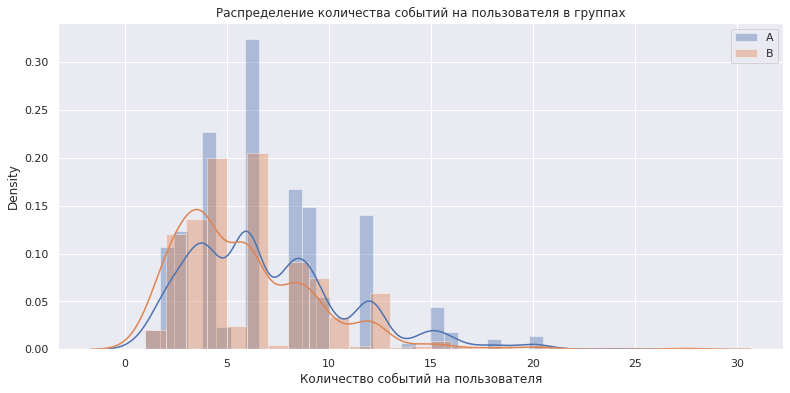

In [52]:
plt.figure(figsize=(13,6))
sns.distplot(df_events_A.groupby('user_id')['event_dt'].count().reset_index()['event_dt'], label='A')
sns.distplot(df_events_B.groupby('user_id')['event_dt'].count().reset_index()['event_dt'], label='B')
plt.title('Распределение количества событий на пользователя в группах')
plt.xlabel('Количество событий на пользователя')
plt.legend()
plt.show()

Судя по графикам распределения в группе А на пользователя приходится чуть больше заказов. Это подтверждает и описательная статистика:

In [53]:
df_events_A.groupby('user_id')['event_dt'].count().reset_index().describe().reset_index().merge(
    df_events_B.groupby('user_id')['event_dt'].count().reset_index().describe().reset_index(), on='index').\
    rename(columns={'event_dt_x':'event_per_user_A', 'event_dt_y':'event_per_user_B'})

,index,event_per_user_A,event_per_user_B
0,count,2747.000000,928.000000
1,mean,7.027303,5.812500
2,std,3.868983,3.483878
3,min,1.000000,1.000000
4,25%,4.000000,3.000000
5,50%,6.000000,5.000000
6,75%,9.000000,8.000000
7,max,24.000000,28.000000


В группе А на пользователя приходится чуть больше заказов, чем в группе В, среднее кол-во заказов на пользователя в группе А - 7.03, медиана равна 6, а в группе В среднее кол-во заказов на пользователя - 5.81, медиана равна 5.

Посмотрим, как число событий распределено по дням

In [54]:
df_events['event_date'] = df_events['event_dt'].dt.date
df_events_A['event_date'] = df_events_A['event_dt'].dt.date
df_events_B['event_date'] = df_events_B['event_dt'].dt.date

In [55]:
def barplot_creator(df, group):
    plt.figure(figsize=(13,6))
    sns.barplot(data=df.groupby('event_date')['event_name'].count().reset_index(), x='event_date', y='event_name', color='#2E8B57')
    plt.title('Распределение количества событий по дням в группе '+ group)
    plt.xlabel('Дата')
    plt.ylabel('Количество событий')
    plt.xticks(rotation=60, ha="right")
    plt.show()

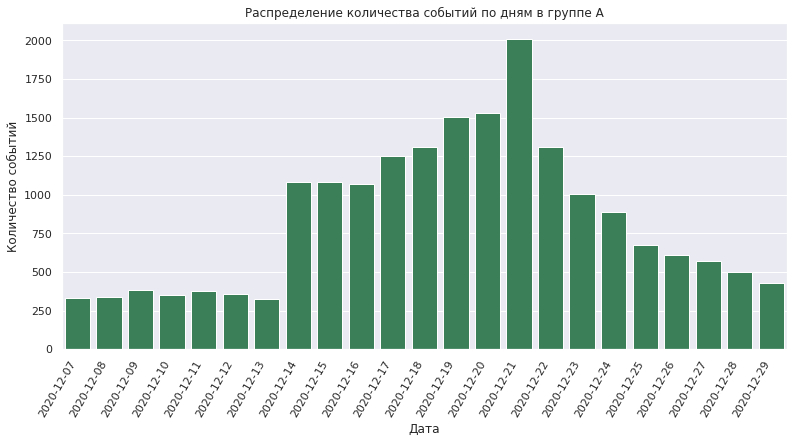

In [56]:
barplot_creator(df_events_A, 'A')

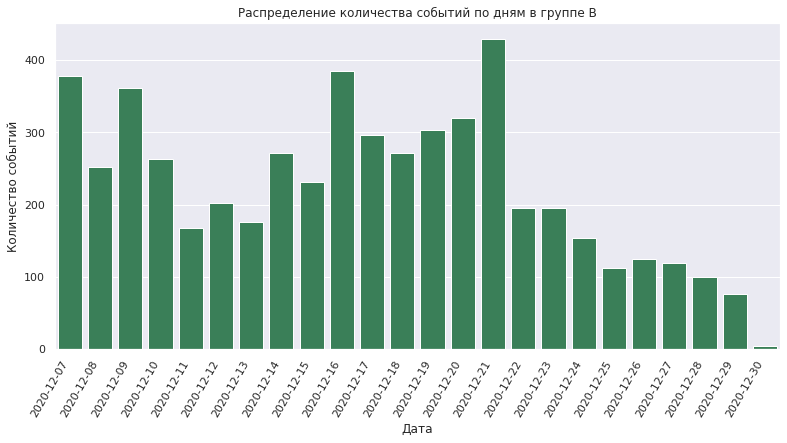

In [57]:
barplot_creator(df_events_B, 'B')

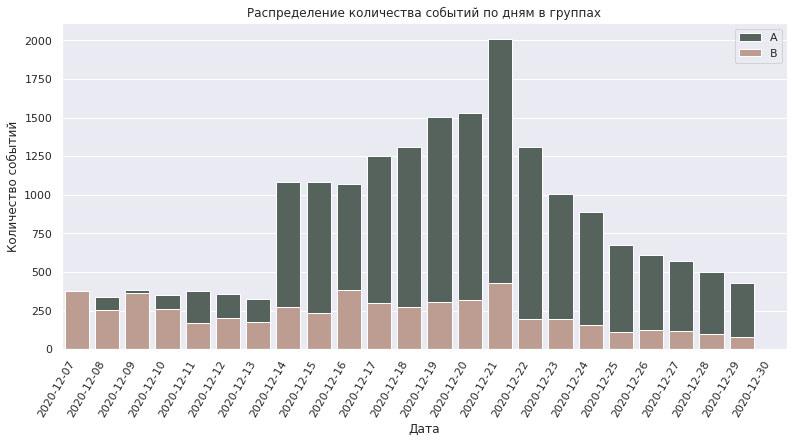

In [58]:
plt.figure(figsize=(13,6))
sns.barplot(data=df_events_A.groupby('event_date')['event_name'].count().reset_index(), x='event_date', y='event_name', color='#2E8B57', saturation=0.15, label='A')
sns.barplot(data=df_events_B.groupby('event_date')['event_name'].count().reset_index(), x='event_date', y='event_name', color='#FF7F50', saturation=0.25, label='B')
plt.title('Распределение количества событий по дням в группах')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=60, ha="right")
plt.legend()
plt.show()

В обеих группах наблюдается всплеск активности 21.12.2020.  
Но активность пользователей неодинакова во времени.  
Группа А была наиболее активна в период 14-21.12.2020.  
Группа В была активна с начала исследуемого периода, также как и группа А до 21.12.2020, после чего наблдаюдается резкий спад.

In [59]:
df_events2 = df_events.copy()
df_events2['event_date'] = pd.to_datetime(df_events2['event_date'], format='%Y-%m-%d') 
df_events2['test_period'] = df_events2['event_date'] - df_events2['first_date']
df_events2[df_events2['test_period'] > '14 days']['test_period'].value_counts()

15 days    171
16 days     94
17 days     86
18 days     80
20 days     69
19 days     60
21 days     33
22 days     31
23 days      4
Name: test_period, dtype: int64

In [60]:
df_events2 = df_events2[df_events2['test_period'] < '15 days']
df_events2.head()

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,event_date,test_period
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test,2020-12-07,0 days
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-07,EU,Android,A,recommender_system_test,2020-12-09,2 days
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test,2020-12-07,0 days
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test,2020-12-08,1 days
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test,2020-12-09,2 days


In [61]:
df_events['user_id'].nunique()

3675

Число участников теста меньше 6000.

In [62]:
df_events2_A = df_events2[df_events2['group'] == 'A']
df_events2_B = df_events2[df_events2['group'] == 'B']


n_login_A2 = df_events2_A[df_events2_A['event_name'] == 'login']['user_id'].nunique()
n_login_B2 = df_events2_B[df_events2_B['event_name'] == 'login']['user_id'].nunique()


n_product_page_A2 = df_events2_A[df_events2_A['event_name'] == 'product_page']['user_id'].nunique()
conversion_product_page_A2 = n_product_page_A2/n_login_A2

n_product_page_B2 = df_events2_B[df_events2_B['event_name'] == 'product_page']['user_id'].nunique()
conversion_product_page_B2 = n_product_page_B2/n_login_B2


n_product_cart_A2 = df_events2_A[df_events2_A['event_name'] == 'product_cart']['user_id'].nunique()
conversion_product_cart_A2 = n_product_cart_A2/n_login_A2

n_product_cart_B2 = df_events2_B[df_events2_B['event_name'] == 'product_cart']['user_id'].nunique()
conversion_product_cart_B2 = n_product_cart_B2/n_login_B2


n_purchase_A2 = df_events2_A[df_events2_A['event_name'] == 'purchase']['user_id'].nunique()
conversion_purchase_A2 = n_purchase_A2/n_login_A2

n_purchase_B2 = df_events2_B[df_events2_B['event_name'] == 'purchase']['user_id'].nunique()
conversion_purchase_B2 = n_purchase_B2/n_login_B2


print('Авторизовавшихся пользователей А:', n_login_A2)
print('Конверсия в просмотр карточек товаров А: {:.2%}'.format(conversion_product_page_A2))
print('Конверсия в просмотр корзины А: {:.2%}'.format(conversion_product_cart_A2))
print('Конверсия в оплаты А: {:.2%}'.format(conversion_purchase_A2))
print('---------------------------------------------------------------')
print('Авторизовавшихся пользователей В:', n_login_B2)
print('Конверсия в просмотр карточек товаров B: {:.2%}'.format(conversion_product_page_B2))
print('Конверсия в просмотр корзины B: {:.2%}'.format(conversion_product_cart_B2))
print('Конверсия в оплаты B: {:.2%}'.format(conversion_purchase_B2))

Авторизовавшихся пользователей А: 2747
Конверсия в просмотр карточек товаров А: 64.80%
Конверсия в просмотр корзины А: 30.00%
Конверсия в оплаты А: 31.74%
---------------------------------------------------------------
Авторизовавшихся пользователей В: 927
Конверсия в просмотр карточек товаров B: 56.42%
Конверсия в просмотр корзины B: 27.51%
Конверсия в оплаты B: 27.62%


**Вывод**: расчеты показали, что в контрольной группе А показатели конверсии выше. То есть ожидаемых результатов введенные изменения не показали. Конверсия снизилась. Но вероятно результаты теста некорректны и использовать их для принятия решений нельзя, так как в данных много ошибок и несоответствий техническому заданию. 

## Оценка результатов A/B-тестирования

Проверим, насколько значимо отличаются конверсии. С помощью Z-критерия проверим гипотезы о равенстве долей.

Сформулируем гипотезы:  
Нулевая Н0 - конверсии в событие в группах равны.  
Альтернативная Н1 - между конверсиями в событие в группах есть значимая разница  

Критический уровень статистической значимости (alpha) зададим равным 0.05 

In [65]:
def z_test(n_event_A, n_event_B, n_loginA, n_loginB, event):
    alpha = 0.05  # критический уровень статистической значимости

    # конверсия в группе А:
    p1 = n_event_A/n_loginA

    # конверсия в группе B:
    p2 = n_event_B/n_loginB

    # конверсия в обеих группах:
    p_combined = (n_event_A + n_event_B) / (n_loginA + n_loginB)

    # разница конверсий в группах
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1-p_combined) * (1/n_loginA + 1/n_loginB))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2


    print('конверсия в ' + event + ' в группе А: {:.2%}'.format(p1))
    print('конверсия в ' + event + ' в группе B: {:.2%}'.format(p2))
    print()
    print('изменение метрики: {:.2%}'.format(p2/p1-1))
    print()
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между конверсиями в ' + event + ' в группах есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в ' + event + ' в группах разными')

Проверим гипотезу о равенстве конверсий в просмотр карточек товаров — событие `product_page`.  

**Нулевая Н0** - конверсии в просмотр карточек товаров (событие `product_page`) в группах равны.  
    

**Альтернативная Н1** - между конверсиями  в просмотр карточек товаров (событие `product_page`) в группах есть значимая разница  

In [66]:
z_test(n_product_page_A2, n_product_page_B2, n_login_A2, n_login_B2, 'product_page')

конверсия в product_page в группе А: 64.80%
конверсия в product_page в группе B: 56.42%

изменение метрики: -12.93%

p-значение:  5.084368080776613e-06
Отвергаем нулевую гипотезу: между конверсиями в product_page в группах есть значимая разница


Конверсия в просмотр карточек товаров в группе B снизилась после внедрения изменений на 12,93%, и это снижение является статистически значимым.

Проверим гипотезу о равенстве конверсий в просмотр корзины — событие `product_cart`.  

**Нулевая Н0** - конверсии в просмотр корзины (событие `product_cart`) в группах равны.  
    

**Альтернативная Н1** - между конверсиями в просмотр корзины (событие `product_cart`) в группах есть значимая разница  

In [67]:
z_test(n_product_cart_A2, n_product_cart_B2, n_login_A2, n_login_B2, 'product_cart')

конверсия в product_cart в группе А: 30.00%
конверсия в product_cart в группе B: 27.51%

изменение метрики: -8.30%

p-значение:  0.15034216422194624
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в product_cart в группах разными


Конверсия в просмотр корзины в группе B снизилась после внедрения изменений на 8,3%, но это снижение не является статистически значимым.

Проверим гипотезу о равенстве конверсий в покупки — событие `purchase`.  

**Нулевая Н0** - конверсии в покупки (событие `purchase`) в группах равны.  
    

**Альтернативная Н1** - между конверсиями в покупки (событие `purchase`) в группах есть значимая разница  

In [68]:
z_test(n_purchase_A2, n_purchase_B2, n_login_A2, n_login_B2, 'purchase')

конверсия в purchase в группе А: 31.74%
конверсия в purchase в группе B: 27.62%

изменение метрики: -13.00%

p-значение:  0.018474632659979617
Отвергаем нулевую гипотезу: между конверсиями в purchase в группах есть значимая разница


Конверсия в покупки в группе B снизилась после внедрения изменений на 13%, и это снижение является статистически значимым.

**Вывод**: Ожидаемых результатов внедренные изменения не принесли. Роста конверсии не наблюдается ни для одного из событий лога. Напротив, конверсия в просмотр карточек товаров и в покупки в группе B снизилась после внедрения изменений на 12,93% и 13% соответственно, и такое снижение является статистически значимым.   
    
Полагаться на результаты теста и принимать решения по его результатам не рекомендуется, так как тест проведен не совсем корректно, не в полном соответствии с ТЗ:
- нет записей лога с событиями в период с 2020-12-31 по 2021-01-04; 
- некорректный интервал отбора новых пользователей. Должен был завершиться на сутки раньше;  
- ожидаемое количество участников теста: 6000 - по факту только 2788;  
- менее 15% аудитории из региона EU - только 7,5%;  
- число участников теста менее 6000 - только 3675 пользователей;  

Также имеются дополнительные факторы, которые могли исказить результаты теста:  
- В даты проведения теста проходит Рождественская и предновогодняя маркетинговая кампания, которая может повлиять на результаты теста и исказить их.  
- Одновременно с исследуемым `тестом recommender_system_test` проводился тест `interface_eu_test`, в котором принимали участие 1602 пользователя из исследуемого теста;  
- пользователи не всегда идут по ожидаемому логическому пути событий от авторизации до покупки.  
    
Следует проработать корректность проведения теста.